In [1]:
import torch 

hives_ids = ["smrpiclient7", "smrpiclient6", "smrpiclient5"]
# hives_ids = ["smrpiclient7"]

# define hive under analysis
hive_under_analysis = hives_ids[0]
# define offset as all data should be utc
timezone_offset_hours = 2
# define if we should reinit our data
DATA_INIT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
import utils.periodogram_dataset as pd
import utils.periodogram_dataset_keras as pdk
import utils.contrastive_pytorch as cp
import utils.contrastive_keras as ck
import utils.data_utils as du
import importlib

importlib.reload(ck)
importlib.reload(pdk)

<module 'utils.periodogram_dataset_keras' from 'C:\\Users\\tymot\\projects\\001.smartula\\smartula-analysis\\smartula-analysis\\notebooks\\utils\\periodogram_dataset_keras.py'>

Preprocess data and remove these with invalid RMS. Save filenames to file

In [7]:
import glob
import os
import math

from scipy.io import wavfile
from tqdm import tqdm
CHECK_FILES = False

if CHECK_FILES:
    folders = [folder for folder in glob.glob(f"..\\measurements\\smartulav2\\smrpiclient*_*\\")]
    for folder in folders:
        print(f"checking folder {folder.split(os.sep)[-2]}", flush=True)
        files = [file for file in glob.glob(f"{folder}*.wav")]
        valid_files = []
        for filename in tqdm(files):
            # check filename and write its filename to list if is valid
            sample_rate, sound_samples = wavfile.read(filename)
            if len(sound_samples.shape) > 1:
                sound_samples = sound_samples.T[0]
            sound_samples = sound_samples/(2.0**31)
            rms = math.sqrt(sum(sound_samples**2)/len(sound_samples))
            if rms < 0.8:
                valid_files.append(filename)
        
        with open(f'{folder}valid-files.txt', 'w') as f:
            f.write("\n".join(valid_files))
else:
    # read files
    valid_files = []
    summary_files = [f for hive_name in hives_ids for f in glob.glob(f"..\\measurements\\smartulav2\\{hive_name}_*\\valid-files.txt")]
    for summary_file in summary_files:
        with open(summary_file, 'r') as f:
            valid_files += f.read().splitlines()
    print(f'got {len(valid_files)} files for {str(hives_ids)}')

got 35899 files for ['smrpiclient7', 'smrpiclient6', 'smrpiclient5']


# Variational autoencoder

preparing train dataset with len: 35899
VAE model training performed on cuda
-> training at epoch 1


100%|██████████| 393/393 [00:20<00:00, 19.15it/s]

-> validating at epoch 1



100%|██████████| 393/393 [00:17<00:00, 22.98it/s]

[ 1/10] train_loss: 974.68406 valid_loss: 330.78709 checkpoint!
-> training at epoch 2



100%|██████████| 393/393 [00:17<00:00, 22.83it/s]

-> validating at epoch 2



100%|██████████| 393/393 [00:17<00:00, 22.78it/s]

[ 2/10] train_loss: 327.11547 valid_loss: 328.08288 checkpoint!
-> training at epoch 3



100%|██████████| 393/393 [00:17<00:00, 22.28it/s]

-> validating at epoch 3



100%|██████████| 393/393 [00:16<00:00, 23.19it/s]

[ 3/10] train_loss: 325.35126 valid_loss: 325.98288 checkpoint!
-> training at epoch 4



100%|██████████| 393/393 [00:16<00:00, 23.20it/s]

-> validating at epoch 4



100%|██████████| 393/393 [00:16<00:00, 23.13it/s]

[ 4/10] train_loss: 323.75697 valid_loss: 323.39692 checkpoint!
-> training at epoch 5



100%|██████████| 393/393 [00:17<00:00, 23.03it/s]

-> validating at epoch 5



100%|██████████| 393/393 [00:16<00:00, 23.50it/s]

[ 5/10] train_loss: 322.86905 valid_loss: 323.06929 checkpoint!
-> training at epoch 6



100%|██████████| 393/393 [00:19<00:00, 20.03it/s]

-> validating at epoch 6



100%|██████████| 393/393 [00:17<00:00, 21.99it/s]

[ 6/10] train_loss: 322.20532 valid_loss: 323.29224 .
-> training at epoch 7



100%|██████████| 393/393 [00:17<00:00, 22.88it/s]

-> validating at epoch 7



100%|██████████| 393/393 [00:17<00:00, 23.05it/s]

[ 7/10] train_loss: 321.38089 valid_loss: 318.83929 checkpoint!
-> training at epoch 8



100%|██████████| 393/393 [00:18<00:00, 20.92it/s]

-> validating at epoch 8



100%|██████████| 393/393 [00:16<00:00, 23.20it/s]

[ 8/10] train_loss: 317.34038 valid_loss: 314.84466 checkpoint!
-> training at epoch 9



100%|██████████| 393/393 [00:17<00:00, 22.93it/s]

-> validating at epoch 9



100%|██████████| 393/393 [00:17<00:00, 22.97it/s]

[ 9/10] train_loss: 312.25993 valid_loss: 314.73113 checkpoint!
-> training at epoch 10



100%|██████████| 393/393 [00:17<00:00, 22.78it/s]

-> validating at epoch 10



100%|██████████| 393/393 [00:16<00:00, 23.16it/s]

[10/10] train_loss: 310.33000 valid_loss: 307.92804 

checkpoint!


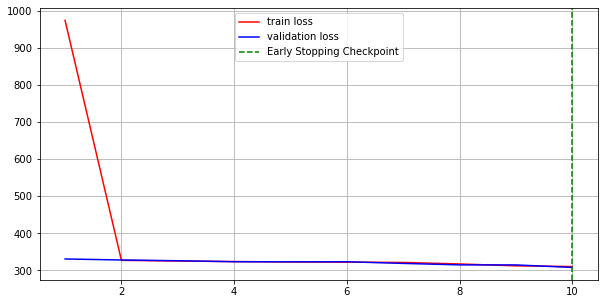

In [8]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

from utils.periodogram_dataset import PeriodogramDataset
from utils.contrastive_pytorch import VAE, train_vae_model
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

PATH = 'models\\vae-apprirary-approach-05022021.pth'
TRAIN = True

modelVAE = VAE(encoder_layer_sizes=[2048, 512, 64], latent_size=16, decoder_layer_sizes=[64, 512, 2048]).to(device)

if TRAIN:
    sound_files = valid_files
    test_size = 0.15
    val_size = 0.15

    print(f"preparing train dataset with len: {len(sound_files)}")
    dataset = PeriodogramDataset(sound_files, hives_ids, slice_freq=(0, 2048))
    test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)
    train_set, val_set, test_set = random_split(dataset,
                                                [(dataset.__len__() - (test_amount + val_amount)), 
                                                 test_amount, val_amount])
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)


    modelVAE = train_vae_model(modelVAE, learning_rate=1e-3, weight_decay=1e-5, num_epochs=10, patience=100,
                                  dataloader_train=train_loader, dataloader_val=val_loader, checkpoint_name=PATH)
else:
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        modelVAE.load_state_dict(torch.load(PATH))
        print('model load success!')
    else:
        print(f'ERROR! There is no file: {PATH}')

# cVAE

In [162]:
target = train_data[0]
background = train_data[1]
print(f'{type(target[0])}/{type(background)}')

<class 'numpy.ndarray'>/<class 'numpy.ndarray'>


In [63]:
import glob

from utils.periodogram_dataset_keras import PeriodogramGenerator
from utils.contrastive_keras import contrastive_keras_vae

bsize = 32

target_hive = "smrpiclient6"
target_valid_file = glob.glob(f"..\\measurements\\smartulav2\\{target_hive}_*\\valid-files.txt")
target_valid_filenames = []
with open(target_valid_file[0], 'r') as f:
    target_valid_filenames = f.read().splitlines()
    
background_hives = ["smrpiclient5", "smrpiclient7"]
background_valid_files = [f for background_hive in background_hives for f in glob.glob(f"..\\measurements\\smartulav2\\{background_hive}_*\\valid-files.txt")]
background_valid_filenames = []
for background_valid_file in background_valid_files:
    with open(background_valid_file, 'r') as f:
        background_valid_filenames += f.read().splitlines()
        
background_valid_filenames = background_valid_filenames[:len(target_valid_filenames)]
        
train_generator = PeriodogramGenerator(target_valid_filenames, background_valid_filenames,
                                       batch_size=bsize, labels=[target_hive], slice_freq=(0, 2048))

cvae_keras, _, _, _, sb_encoder, cvae_decoder = contrastive_keras_vae(input_dim=2048, intermediate_dim=[512, 64], latent_dim=16,
                                               disentangle=True, gamma=1, batch_size=bsize)

history = cvae_keras.fit(train_generator, epochs=20, batch_size=bsize, verbose=1)


Epoch 1/20
386/386 [==============================] - 51s 132ms/step - loss: 11.2057
Epoch 2/20
386/386 [==============================] - 46s 119ms/step - loss: 9.5479
Epoch 3/20
386/386 [==============================] - 45s 118ms/step - loss: 9.2809
Epoch 4/20
386/386 [==============================] - 46s 118ms/step - loss: 9.0541
Epoch 5/20
386/386 [==============================] - 47s 121ms/step - loss: 8.8734
Epoch 6/20
386/386 [==============================] - 46s 119ms/step - loss: 8.7631
Epoch 7/20
386/386 [==============================] - 48s 123ms/step - loss: 8.6722
Epoch 8/20
386/386 [==============================] - 47s 121ms/step - loss: 8.6254
Epoch 9/20
386/386 [==============================] - 46s 120ms/step - loss: 8.5728
Epoch 10/20
386/386 [==============================] - 46s 120ms/step - loss: 8.5581
Epoch 11/20
386/386 [==============================] - 47s 122ms/step - loss: 8.5170
Epoch 12/20
386/386 [==============================] - 48s 123ms/step - l

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from utils.periodogram_dataset import PeriodogramDataset
from torch.utils.data import DataLoader
from utils.data_utils import normal_pdf

hives_ids_test = ["smrpiclient3"]
hut_sounds_files = [f for hive_name_test in hives_ids_test for f in glob.glob(f"..\\measurements\\smartulav2\\{hive_name_test}_*\\*.wav")]
all_sound_files = [f for hive_name in hives_ids for f in glob.glob(f"..\\measurements\\smartulav2\\{hive_name}_*\\*.wav")]

# pytorch
hut_dataset = PeriodogramDataset(hut_sounds_files, hives_ids_test, slice_freq=(0, 2048))
all_sound_dataset = PeriodogramDataset(all_sound_files, hives_ids, slice_freq=(0, 2048))

# get indices for all_sound_dataset
subset_indices = np.random.randint(0, len(all_sound_dataset), len(hut_dataset))
dataset = torch.utils.data.Subset(all_sound_dataset, subset_indices)

test_loss = []
train_loss = []
with torch.no_grad():
    modelVAE.eval()
    print(f'validating on test set', flush=True)
    for input_data in tqdm(hut_dataset, position=0, leave=True):
        if input_data:
            input_data = torch.Tensor(input_data[0]).to(device)
            output, mean, var = modelVAE(input_data.to(device))
            test_loss.append(F.mse_loss(output, input_data, reduction='sum').cpu().numpy())
            
    print(f'validating on training set')
    for input_data in tqdm(dataset, position=0, leave=True):
        if input_data:
            input_data = torch.Tensor(input_data[0]).to(device)
            output, _, _ = modelVAE(input_data.to(device))
            train_loss.append(F.mse_loss(output, input_data, reduction='sum').cpu().numpy())
                
test_loss_avg = np.mean(test_loss)
train_loss_avg = np.mean(train_loss)
                                       
print(f'test loss vs train loss : {test_loss_avg:.2f} : {train_loss_avg:.2f}')
                                    

validating on test set


  3%|▎         | 75/2452 [00:00<00:06, 373.70it/s]

validating on training set


100%|██████████| 2452/2452 [00:06<00:00, 364.94it/s]

test loss vs train loss : 9.49 : 5.75


In [54]:
import tensorflow as tf

from operator import itemgetter 
from utils.periodogram_dataset_keras import PeriodogramGenerator, read_sound_file
from tqdm import tqdm 

hut_sounds =  np.array([read_sound_file(f, (0, 2048)) for f in tqdm(hut_sounds_files)])
mean, var, latent = sb_encoder.predict(hut_sounds)
zeros = np.zeros_like(latent)
decoder_input = np.concatenate((zeros, latent), axis=1)
cvae_output = cvae_decoder.predict(decoder_input)
loss = tf.keras.losses.mean_squared_error(hut_sounds, cvae_output)

print(f'MSE loss for hive under test: {np.mean(loss)}')

100%|██████████| 2452/2452 [00:04<00:00, 514.05it/s]


In [98]:
subset_indices = np.random.randint(0, len(background_valid_filenames), len(hut_sounds))

background_train_sound_files = list(itemgetter(*subset_indices)(background_valid_filenames))
bg_sounds = np.array([read_sound_file(f, (0, 2048)) for f in tqdm(background_train_sound_files)])
mean, var, latent = sb_encoder.predict(bg_sounds)
zeros = np.zeros_like(latent)
decoder_input = np.concatenate((zeros, latent), axis=1)
cvae_output = cvae_decoder.predict(decoder_input)
loss = tf.keras.losses.mean_squared_error(hut_sounds, cvae_output)

print(f'MSE loss for hive under test: {np.mean(loss)}')


# Data Preprocessing

Here we load train data sound samples and prepare spectrogram, periodogram and mfcc features (along with some data to visualize this). We should provide data with **utc timestamps** as it will be shifted with `timezone_offset_hours` var. What we also do is remove those samples which has strange rms signal. Threshold 0.8 was chosen based on `plot_distribution` output.


In [ ]:
import numpy as np
import glob
import librosa

from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.io import wavfile
from scipy.fftpack import fft, fftfreq

sound_time_ms = 2000
# ~93 ms for fft window
nfft = 4096
# ~34% overlapping
hop_len = (nfft//3) + 30
# This can be manipulated to adjust number of bins for conv layer
fmax = 2750

hives_data = []
rmses = {}
max_to_norm = 0

if DATA_INIT:
    for idx, hive_id in enumerate(hives_ids):
        sound_files = [f for f in glob.glob(f"..\\measurements\\smartulav2\\{hive_id}_*\\*.wav")]
        print(f"Sound data preparation for hive: {hive_id} which has {len(sound_files)} recordings...", end=' ', flush=True)
        for file in tqdm(sound_files):
            sample_rate, sound_samples = wavfile.read(file)
            sound_samples = sound_samples.T[0]/(2.0**31)
            rms = np.sqrt(sum(sound_samples**2)/len(sound_samples))
            if rms < 0.7:    # that threshold was observed from plot_distribution() function
                # calculate timestamp
                filename = file.rsplit('\\', 1)[-1]
                utc_timestamp = filename[filename.index('-')+1:].rsplit(".wav")[0]
                sound_datetime = datetime.strptime(utc_timestamp, '%Y-%m-%dT%H-%M-%S') + timedelta(hours=timezone_offset_hours)
                
                # calculate mfcc feature
                mfccs = librosa.feature.mfcc(y=sound_samples, sr=sample_rate, n_fft=nfft, hop_length=hop_len, n_mfcc=13)
                np_mfcc_avg = np.mean(mfccs, axis=1)
                
                # calculate spectrogram
                spectrogram = librosa.core.stft(sound_samples, n_fft=nfft, hop_length=hop_len)
                spectrogram_magnitude = np.abs(spectrogram)
                spectrogram_phase = np.angle(spectrogram)
                spectrogram_db = librosa.amplitude_to_db(spectrogram_magnitude, ref=np.max)
                frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=nfft)
                times = (np.arange(0, spectrogram_magnitude.shape[1])*hop_len)/sample_rate
                freq_slice = np.where((frequencies < fmax))
                frequencies = frequencies[freq_slice]
                spectrogram_db = spectrogram_db[freq_slice, :][0]
                spectrogram_mean = np.mean(spectrogram_db, axis=1)
                # decimate?
                # spectrogram_db_decimated = decimate(spectrogram_db.T, 4).T
                # frequencies_decimated = decimate(frequencies, 4)

                #calculate periodogram
                periodogram = fft(sound_samples, n=sample_rate)
                periodogram = abs(periodogram[1:int(len(periodogram)/2)])
                periodogram_freq = fftfreq(len(sound_samples)//(sound_time_ms//1000), 1/sample_rate)
                periodogram_freq = periodogram_freq[:(len(periodogram_freq)//2)-1]
                
                hives_data.append(
                    {
                        'datetime': sound_datetime,
                        'id': hive_id,
                        'samples': sound_samples,
                        'freq':
                            {
                                'spectrogram':
                                    {
                                        'frequencies': frequencies,
                                        'time': times,
                                        'spectrogram_full_db': spectrogram_db,
                                        'spectrogram_mean': spectrogram_mean
                                    },
                                'periodogram':
                                    {
                                        'frequencies': periodogram_freq,
                                        'samples': periodogram
                                    }
                            },
                        'features':
                            {
                                'mfcc_avg': np_mfcc_avg
                            }
                    }
                )
        print(" done.")
        
    print("saving data on disc...", end=' ')
    np.save('data/raw_hives_data.npy', hives_data, allow_pickle=True)
    print("done.")
else:
    hives_data = np.load('data/raw_hives_data.npy', allow_pickle=True)
    
print(f"got full dataset of {len(hives_data)} sound samples")

### Data preprocessing 

Here we perform scaling standarization etc.
 

In [ ]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

sc = StandardScaler()
mm = MinMaxScaler()

# extract every spectrogram from hives data list and standarize every periodogram from stft 
# so data for spectrogram will have zero mean and unit variance + scale every standarized periodogram
print('preparing spectrograms...', end=' ', flush=True)
spectrograms = [hive_data['freq']['spectrogram']['spectrogram_full_db'] for hive_data in hives_data]
# standarized_spectrograms = [sc.fit_transform(spectrogram.T).T for spectrogram in tqdm(spectrograms)]
scaled_spectrogram = [mm.fit_transform(spectrogram.T).T for spectrogram in tqdm(spectrograms, position=0, leave=True)]
print('done.')

# get datatime, names and mfcc
print('getting mfccs', end=' ')
datetimes = [hive_data['datetime'] for hive_data in hives_data]
names = [hive_data['id'] for hive_data in hives_data]
mfccs = [hive_data['features']['mfcc_avg'] for hive_data in hives_data]
print('done.')

# standarize and scale mean spectrogram for sounds
print('preparing spectrogram means', end=' ')
spectrograms_mean = [hive_data['freq']['spectrogram']['spectrogram_mean'] for hive_data in hives_data]
standarized_spectrograms_mean = StandardScaler().fit_transform(spectrograms_mean)
scaled_spectrograms_means = MinMaxScaler().fit_transform(standarized_spectrograms_mean)
print('done.')

# prepare truncated periodogram
end_frequency = 2048
print(f'preparing truncated periodograms ({end_frequency})', end=' ', flush=True)
periodograms = [hive_data['freq']['periodogram']['samples'][:end_frequency] for hive_data in hives_data]
periodograms = [mm.fit_transform(perio.reshape(-1, 1)).T for perio in tqdm(periodograms, position=0, leave=True)]
print('done.')

sounds = list(zip(scaled_spectrogram, mfccs, scaled_spectrograms_means, periodograms, datetimes, names))

sounds_data = pd.DataFrame(sounds, columns=['spectrogram', 'mfccs', 'spectrogram_mean', 'periodogram', 'datetime', 'name'])
sounds_data['datetime'] = pd.to_datetime(sounds_data['datetime'])
sounds_hive_data = sounds_data[sounds_data['name'] == hive_under_analysis]

print(f"Got dataset of size: {len(sounds)}")

## Train CONTRASTIVE AE - keras

In [ ]:
sounds_data[sounds_data['name'] == 'smrpiclient7']['periodogram'].to_numpy().shape

In [ ]:
from utils.contrastive_keras import contrastive_keras_vae
from sklearn.preprocessing import MinMaxScaler

target_keras = np.stack(sounds_data[sounds_data['name'] == 'smrpiclient7']['periodogram'].to_numpy()[:3000]).squeeze()
background_keras = np.stack(sounds_data[sounds_data['name'] == 'smrpiclient6']['periodogram'].to_numpy()[:3000]).squeeze()

print(f'training cvae (keras) with target of shape: {target_keras.shape} '
    f'and background of shape: {background_keras.shape}')

assert(target_keras.shape == background_keras.shape)

cvae_keras, cvae_fg, z_encoder_keras, s_encoder_keras, cvae_keras_decoder = contrastive_keras_vae(
    input_dim=2048, intermediate_dim=512, latent_dim=16, disentangle=True, gamma=1)
history = cvae_keras.fit([target_keras, background_keras], epochs=50, batch_size=100, 
                         validation_data=([target_keras, background_keras], None), verbose=1)

## Train BASIC AE
Here we train basic fully connected autoencoder on data from particular hive

In [ ]:
import torch 
import os

from torch.utils import data as tdata
from utils.data_utils import prepare_dataset1d
from utils.autoencoder_utils import BasicAutoencoder, train_model

TRAIN_MODEL = False
PATH = 'basic_ae.pth'

modelBasicAE = BasicAutoencoder().to(device)

if TRAIN_MODEL:
    train_dataloader, val_dataloader = prepare_dataset1d(sounds_hive_data['spectrogram_mean'], train_ratio=0.8, batch_size=64)
    modelBasicAE = train_model(modelBasicAE,
                           learning_rate=1e-3, weight_decay=1e-5, num_epochs=10, patience=20,
                           dataloader_train=train_dataloader, dataloader_val=val_dataloader,
                           checkpoint_name=PATH)
else:
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        modelBasicAE.load_state_dict(torch.load(PATH))
        print('model load success!')
    else:
        print(f'ERROR! There is no file: {PATH}')

## Train CONV AE

Here we train convolutional autoencoder on data from particular hive

In [ ]:
from torch.utils import data as tdata
from utils.data_utils import prepare_dataset2d
from utils.autoencoder_utils import ConvAutoencoder, train_model

TRAIN_MODEL = True
PATH = 'conv_ae.pth'

modelConvAE = ConvAutoencoder().to(device)

if TRAIN_MODEL:
    train_set, val_set = prepare_dataset2d(sounds_hive_data['spectrogram'], train_ratio=0.8)
    
    dataloader_train = tdata.DataLoader(train_set, batch_size=6, shuffle=True)
    dataloader_val = tdata.DataLoader(val_set, batch_size=6, shuffle=True)
    
    modelConvAE = train_model(modelConvAE,
                               learning_rate=1e-3, weight_decay=1e-6, num_epochs=100, patience=20,
                               dataloader_train=dataloader_train, dataloader_val=dataloader_val,
                               checkpoint_name=PATH)
else:
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        modelConvAE.load_state_dict(torch.load(PATH))
        print('model load success!')
    else:
        print(f'ERROR! There is no such file: {PATH}')

## Train VAE

Here we train vae autoencoder on data from particular hive

In [ ]:
import torch

from torch.utils import data as tdata
from torchvision import transforms
from utils.data_utils import prepare_dataset1d
from utils.contrastive_pytorch import VAE, train_vae_model
from utils.customdataset import CustomDataset

TRAIN_MODEL = True
PATH = 'vae.pth'

modelVAE = VAE(encoder_layer_sizes=[2048, 512, 64], latent_size=16, decoder_layer_sizes=[64, 512, 2048])

if TRAIN_MODEL:
    data = torch.Tensor(sounds_hive_data['periodogram'])
    data = data[:, None, :]
    idx_split = data.size(0)*80//100
    train_dataset = CustomDataset(data[:idx_split], should_scale=True)
    val_dataset = CustomDataset(data[idx_split:], should_scale=True)
    train_dataloader = tdata.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = tdata.DataLoader(val_dataset, batch_size=64, shuffle=True)
    
    modelVAE = train_vae_model(modelVAE, learning_rate=1e-3, weight_decay=1e-5, num_epochs=100, patience=100,
                              dataloader_train=train_dataloader, dataloader_val=val_dataloader, checkpoint_name=PATH)
else:
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        modelVAE.load_state_dict(torch.load(PATH))
        print('model load success!')
    else:
        print(f'ERROR! There is no such file: {PATH}')

# Encode data

In [ ]:
import matplotlib.pyplot as plt
import random
import torch
from scipy.io import wavfile

# read just sample file as probably all has the same sampling rate
sample_rate, samples = wavfile.read('C:\\Users\\tymot\\projects\\001.smartula\\smartula-analysis\\smartula-analysis'
                           '\\measurements\\smartulav2\\smrpiclient6_10082020-15092020\\DEADBEEF94-2020-08-10T03-11-50.wav')
idx = random.randint(0, sounds_hive_data.shape[0] - 1)
idx = 2240
with torch.no_grad():   
    modelConvAE.eval()
    modelBasicAE.eval()
    modelVAE.eval()
    
    # Get sound from sounds hive data (with respect to hive under analysis)
    sound = sounds_hive_data.iloc[idx]
    
    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    fig.suptitle(f'Convolutional Autoencoder real vs output for sample id: {idx}')
    fig.tight_layout(pad = 3.0)

    frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=nfft)
    freq_slice = np.where((frequencies < fmax))
    frequencies = frequencies[freq_slice]
    times = (np.arange(0, sound['spectrogram'].shape[1])*hop_len)/sample_rate
    elem = sound['spectrogram']
    elem = elem[None, None, :, :]
    elem = torch.Tensor(elem).to(device)
    
    elem_mean = sound['spectrogram_mean']
    elem_mean = elem_mean[None, :]
    elem_mean = torch.Tensor(elem_mean).to(device)
    
    axs[0][0].set_title('real spectrogram')
    axs[0][0].pcolormesh(times, frequencies, sound['spectrogram'])
    axs[0][1].set_title('encoded conv2d')
    axs[0][1].pcolormesh(times, frequencies, modelConvAE(elem.to(device)).cpu().numpy().squeeze())
    
    # prepare data for vae prediction
    freqs = np.arange(sound['periodogram'].shape[1])
    input_data = torch.Tensor(sound['periodogram']).to(device)
    vae_output, _, _ = modelVAE(input_data)
    
    # prepare data for cvae prediction
    s_mean, s_log_var, s = s_encoder_keras.predict(sound['periodogram'])
    latent = np.concatenate((np.zeros_like(s), s), axis = 1)
    cvae_output = cvae_keras_decoder.predict(latent)

    axs[1][0].set_title('spectrogram mean')
    axs[1][0].plot(sound['spectrogram_mean'], label='real', color='blue')
    axs[1][0].plot(modelBasicAE(elem_mean).cpu().numpy().squeeze(), label='encoded', color='red')
    axs[1][0].legend()
    
    axs[1][1].set_title('periodogram')
    axs[1][1].plot(freqs, periodogram_df, label='real', color='blue')
    axs[1][1].plot(freqs, vae_output.cpu().numpy().squeeze(), label='vae encoded', color='red')
    axs[1][1].plot(freqs, cvae_output.squeeze(), label='cvae encoded', color='green')
    axs[1][1].legend()
    
    plt.show()

# Add temperature/humidity/gas

In [ ]:
from utils.data_utils import read_sensor_data

start_time = '2020-08-10 00:00:00'
end_time = '2020-09-16 00:00:00'
print(f"extracting data for hive under analysis: {hive_under_analysis} from {start_time} to {end_time}...")

df_hives_sound = pd.DataFrame(sounds_data)
df_hive_sound_ua = df_hives_sound[(df_hives_sound['name'] == hive_under_analysis)
                                 & (df_hives_sound['datetime'] > start_time)
                                 & (df_hives_sound['datetime'] < end_time)]
df_hive_sound_ua.set_index('datetime', inplace=True)
print(f"-> prepared base of {df_hive_sound_ua.count()['spectrogram']} number of sound spectrums <-")

df_hive_temperature_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-temperature.csv',
                                          hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'temperature')
df_hive_humidity_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-humidity.csv',
                                       hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'humidity')
df_hive_alcohol_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-alcohol.csv',
                                      hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'alcohol')
df_hive_aceton_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-aceton.csv',
                                     hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'aceton')
df_hive_amon_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-jon-amonowy.csv',
                                   hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'jon-amonowy')
df_hive_toluen_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-toluen.csv',
                                     hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'toluen')
df_hive_co2_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-co2.csv',
                                    hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'co2')
df_hive_siarkowodor_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-siarkowodor.csv',
                                          hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'siarkowodor')
df_hive_metanotiol_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-metanotiol.csv',
                                         hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'metanotiol')
df_hive_trimetyloamina_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-trimetyloamina.csv',
                                         hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'trimetyloamina')
df_hive_wodor_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-wodor.csv',
                                    hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'wodor')
df_hive_co_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-co.csv',
                                 hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'co')


Check autocorrelation for specific features

In [ ]:
from utils.data_utils import merge_dataframes_ontimestamp, merge_columns
from utils.autoencoder_utils import conv2d_encode, basic_ae_encode
from utils.contrastive_pytorch import vae_encode
from utils.contrastive_keras import cvae_encode

df_hive_data = merge_dataframes_ontimestamp(df_hive_sound_ua,
                                            df_hive_temperature_ua, df_hive_humidity_ua,
                                            df_hive_alcohol_ua, df_hive_aceton_ua, df_hive_amon_ua, df_hive_toluen_ua, df_hive_co2_ua,
                                            df_hive_siarkowodor_ua, df_hive_metanotiol_ua, df_hive_trimetyloamina_ua, df_hive_wodor_ua,
                                            df_hive_co_ua)

df_hive_data['conv_ae'] = conv2d_encode(modelConvAE, df_hive_data['spectrogram'].to_list())
df_hive_data['basic_ae'] = basic_ae_encode(modelBasicAE, df_hive_data['spectrogram_mean'].to_list())
df_hive_data['vae'] = vae_encode(modelVAE, df_hive_data['periodogram'].to_list()).tolist()
df_hive_data['cvae_s'] = cvae_encode(s_encoder_keras, df_hive_data['periodogram']).tolist()
df_hive_data['cvae_z'] = cvae_encode(z_encoder_keras, df_hive_data['periodogram']).tolist()

df_hive_data['bae_feature_vector'] = merge_columns(df_hive_data, ['basic_ae', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])
df_hive_data['conv_feature_vector'] = merge_columns(df_hive_data, ['conv_ae', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])
df_hive_data['mfcc_feature_vector'] = merge_columns(df_hive_data, ['mfccs', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])
df_hive_data['vae_feature_vector'] = merge_columns(df_hive_data, ['vae', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])
df_hive_data['cvae_s_feature_vector'] = merge_columns(df_hive_data, ['cvae_s', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])
df_hive_data['cvae_z_feature_vector'] = merge_columns(df_hive_data, ['cvae_z', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])

# SVM classification 

In [ ]:
from sklearn.preprocessing import StandardScaler
from utils.data_utils import search_best_night_day

start_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4]

df_hive_data_scaled = pd.DataFrame(df_hive_data)

# data for convolutional autoencoder
df_hive_data_scaled['conv_feature_vector'] = StandardScaler().fit_transform(df_hive_data['conv_feature_vector'].values.tolist()).tolist()

# data for basic autoencoder
df_hive_data_scaled['bae_feature_vector'] = StandardScaler().fit_transform(df_hive_data['bae_feature_vector'].values.tolist()).tolist()

# data for mfcc features
df_hive_data_scaled['mfcc_feature_vector'] = StandardScaler().fit_transform(df_hive_data['mfcc_feature_vector'].values.tolist()).tolist()

# data for vae features
df_hive_data_scaled['vae_feature_vector'] = StandardScaler().fit_transform(df_hive_data['vae_feature_vector'].values.tolist()).tolist()

# data for cvae s features
df_hive_data_scaled['cvae_s_feature_vector'] = StandardScaler().fit_transform(df_hive_data['cvae_s_feature_vector'].values.tolist()).tolist()

# data for cvae s features
df_hive_data_scaled['cvae_z_feature_vector'] = StandardScaler().fit_transform(df_hive_data['cvae_z_feature_vector'].values.tolist()).tolist()

# data for plain mfcc 
mfccs = [hive_data['features']['mfcc_avg'] for hive_data in hives_data if hive_data['id'] == hive_under_analysis]
mfccs = StandardScaler().fit_transform(mfccs)
datetimes = [hive_data['datetime'] for hive_data in hives_data if hive_data['id'] == hive_under_analysis]
mfccs_data = list(zip(datetimes, mfccs))
pd_mfcc_data = pd.DataFrame(mfccs_data, columns=['datetime', 'mfcc'])
pd_mfcc_data.set_index('datetime', inplace=True)

# calculate one class SVM match
print('calculating mfccs match...', end=' ', flush=True)
mfcc_accs = search_best_night_day(pd_mfcc_data, 'mfcc', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(mfcc_accs)}/{len(mfcc_accs[0])}')
print('calculating conv ae feature vector match...', end=' ', flush=True)
conv_ae_accs = search_best_night_day(df_hive_data_scaled, 'conv_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(conv_ae_accs)}/{len(conv_ae_accs[0])}')
print('calculating basic ae feature vector match...', end=' ', flush=True)
bae_accs = search_best_night_day(df_hive_data_scaled, 'bae_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(bae_accs)}/{len(bae_accs[0])}')
print('calculating mfccs extended feature vector match...', end=' ', flush=True)
mffce_accs = search_best_night_day(df_hive_data_scaled, 'mfcc_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(mffce_accs)}/{len(mffce_accs[0])}')
print('calculating vae feature vector match...', end=' ', flush=True)
vae_accs = search_best_night_day(df_hive_data_scaled, 'vae_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(vae_accs)}/{len(vae_accs[0])}')
print('calculating cvae s feature vector match...', end=' ', flush=True)
cvae_accs_s = search_best_night_day(df_hive_data_scaled, 'cvae_s_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(cvae_accs_s)}/{len(cvae_accs_s[0])}')
print('calculating cvae z feature vector match...', end=' ', flush=True)
cvae_accs_z = search_best_night_day(df_hive_data_scaled, 'cvae_z_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(cvae_accs_z)}/{len(cvae_accs_z[0])}')

In [ ]:
from utils.data_utils import plot_hour_shift

plot_hour_shift(mfcc_accs, conv_ae_accs, bae_accs, mffce_accs, vae_accs, cvae_accs_s, cvae_accs_z,
                labels_list=['mfcc', 'conv', 'bae', 'mfcce', 'vae', 'cvae_s', 'cvae_z'],
                xticklabels=[str(start_hour) for start_hour in start_hours],
                save_path = 'data\\outputs\\zs_encoder_0_s.png')

Visualize on 2D map, we basically perform TSNE and PCA dimension reduction in order to visualize night and day. Probably this will be not efficent but it is worth to give a shot.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

start_hour = 23
end_hour = 2

reduce_df = pd.DataFrame(df_hive_data)
reduce_df['feature_vector'] = StandardScaler().fit_transform(df_hive_data['bae_feature_vector'].values.tolist()).tolist()

reduced_ae_pca = PCA(n_components=2).fit_transform(reduce_df['feature_vector'].values.tolist())
reduced_ae_tsne =  TSNE(n_components=2, perplexity=100, learning_rate=500).fit_transform(reduce_df['feature_vector'].values.tolist())
is_night_list = (reduce_df.index.hour >= start_hour) | (reduce_df.index.hour <= end_hour)
                
colors = ['red', 'green', 'blue', 'yellow']
labels = ['day', 'night']

fig, axs = plt.subplots(2, figsize=(10,10))

axs[0].scatter(x=[data[0] for data in reduced_ae_pca],
               y=[data[1] for data in reduced_ae_pca],
               c=[colors[night] for night in is_night_list],
              alpha=0.3)
axs[0].set_title('PCA')

axs[1].scatter(x=[data[0] for data in reduced_ae_tsne],
               y=[data[1] for data in reduced_ae_tsne],
               c=[colors[night] for night in is_night_list],
              alpha=0.3)
axs[1].set_title('TSNE')

plt.show()

In [ ]:
pca = PCA().fit(reduce_df['feature_vector'].values.tolist())

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');




In [ ]:
import matplotlib

def plot_distribution(distribution_dict, bin_size):
    """ Plotting distribiution for dictionary elements"""
    colors = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple']
    rms_max = 0
    rms_min = 65535
    for k, v in rmses.items():
        if np.max(v) > rms_max:
            rms_max = np.max(v)
        if np.min(v) < rms_min:
            rms_min = np.min(v)
        
    plt.figure()
    for idx, (k, v) in enumerate(distribution_dict.items()):
        plt.hist(v, color=colors[idx%len(colors)], bins=int(np.abs(rms_max-rms_min)/bin_size))
    plt.show()

Part of code for calculating autocorrelaction for specific feature

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

%matplotlib widget

features = ['conv_ae', 'humidity', 'temperature',
            'alcohol', 'aceton', 'jon-amonowy',
            'toluen', 'co2', 'siarkowodor',
            'metanotiol', 'trimetyloamina', 'wodor', 'co']

feature = features[12]
data_to_autocorr = df_hive_co_ua

roll_len = 3
interval = (data_to_autocorr.index[2] - data_to_autocorr.index[1]).seconds//60%60

y2 = data_to_autocorr[feature].rolling(window=roll_len).mean().values
y_corr = y2[roll_len:]
x_corelation = np.arange(start=0, step=2, stop=150)

fig, axes = plt.subplots(1, figsize=(8,5))
x = plot_acf(y_corr, lags=x_corelation, zero=False, ax=axes)
x_raw = acf(y_corr, nlags=150)
axes.set_title(f'{feature} autocorrelaction')
axes.set_xlabel(f'Lag (1 lag = {interval} minutes)') 
axes.set_ylabel('Correlation')
axes.set_xticks(np.arange(0, 151, step=10))

print(f'{feature} with max {max(x_raw[60:]):.2f} at {60 + np.argmax(x_raw[60:])}')

# temperature with max 0.74 at 93 (15 mint)
# humidity with max 0.58 at 92 (15 min)
# alcohol with max 0.53 at 134 (10 min)
# aceton with max 0.52 at 133 (10 min)
# jon-amonowy with max 0.57 at 133 (10 min)
# toluen with max 0.52 at 134 (10 min)
# co2 with max 0.54 at 133 (10 min)
# siarkowodor with max 0.16 at 142 (10 min)
# metanotiol with max 0.34 at 140 (10 min)
# trimetyloamina with max 0.56 at 138 (10 min)
# wodor with max 0.14 at 142 (10 min)
# co with max 0.62 at 134 (10 min)

In [ ]:
import importlib
import utils.autoencoder_utils as ae
import utils.data_utils as du
import utils.customdataset as cd
import utils.contrastive_pytorch as cp
import utils.contrastive_keras as ck
import utils.periodogram_dataset as pd

importlib.reload(pd)
